

------------------------------------------------------------------------------------------------------------------------
Plots and Metric Values of Part1 are as follows: 

Metrics for the image 1:

Precision: 0.9545192834523555
Recall: 0.8860016981221527
F-score: 0.9189851292058105



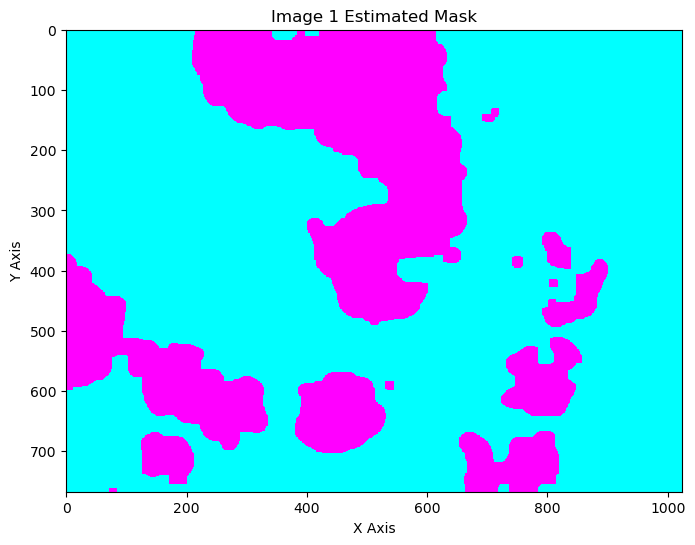

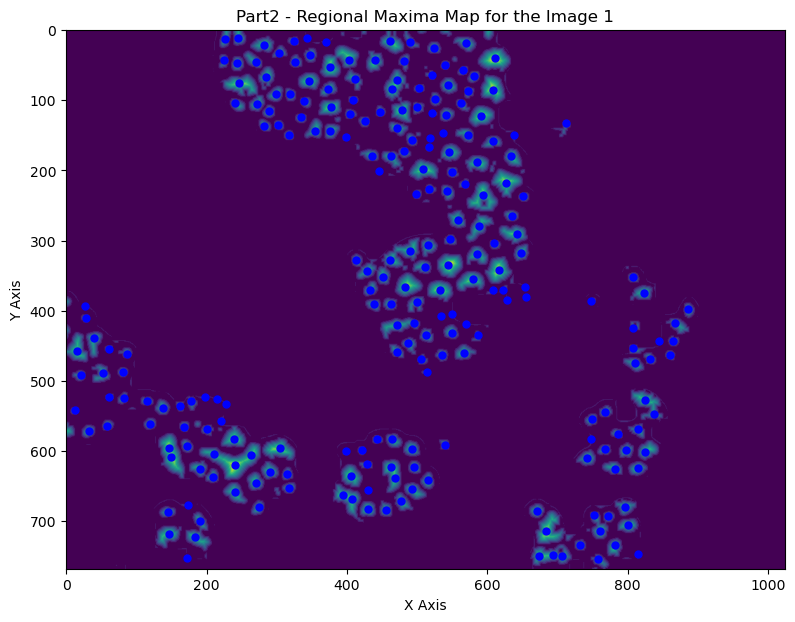

Part-2 Image-1 Metrics:

The cell-level precision, recall, and accuracy metric values for image 1 are as follows: 

Precision: 0.905982905982906
Recall: 0.8760330578512396
F-score: 0.8907563025210083

Cell-level dice index and intersection over union metrics of Part3:

For Threshold being 0.50: 

Dice Index: 0.8034188034188035
Intersection Over Union: 0.6923076923076923

For Threshold being 0.75: 

Dice Index: 0.5555555555555556
Intersection Over Union: 0.09401709401709402

For Threshold being 0.90: 

Dice Index: 0.021367521367521368
Intersection Over Union: 0.0



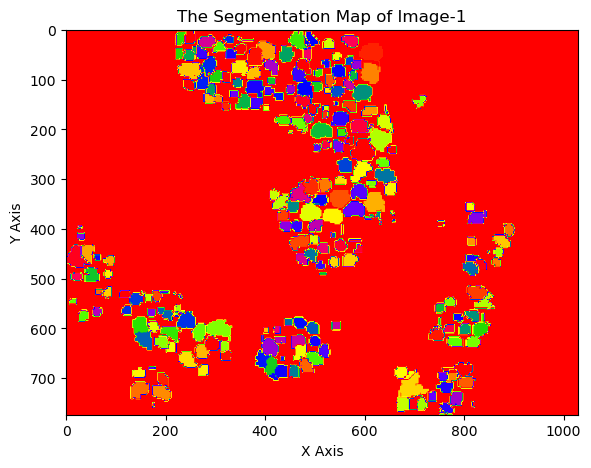

------------------------------------------------------------------------------------------------------------------------
Plots and Metric Values of Part1 are as follows: 

Metrics for the image 2:

Precision: 0.9810016779955064
Recall: 0.9249381759675833
F-score: 0.9521453688893524



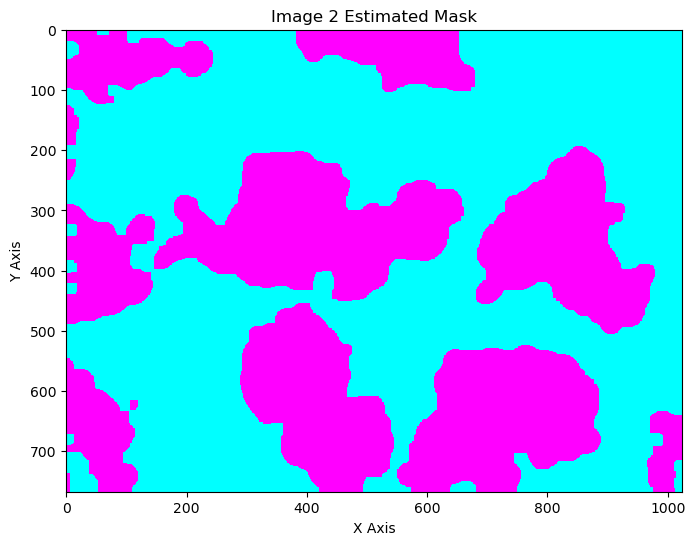

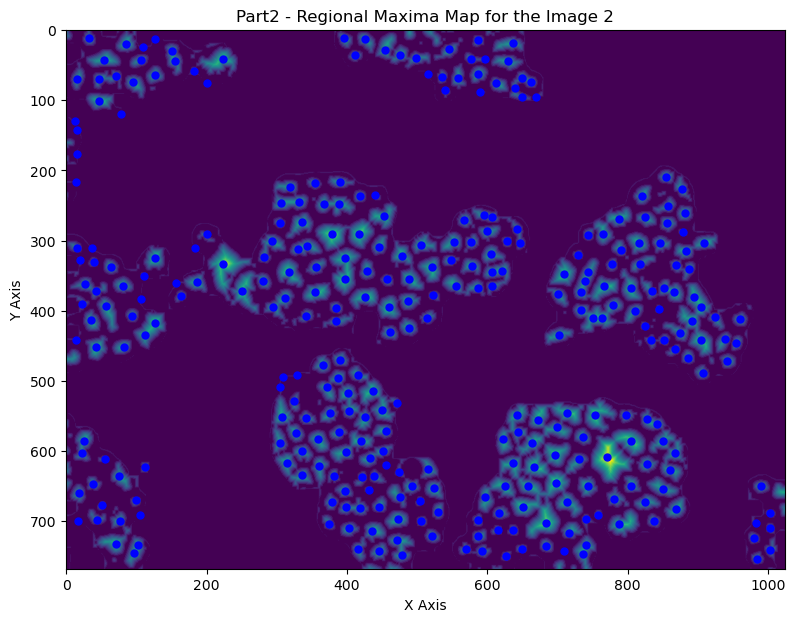

Part-2 Image-2 Metrics:

The cell-level precision, recall, and accuracy metric values for image 2 are as follows: 

Precision: 0.9206349206349206
Recall: 0.932475884244373
F-score: 0.9265175718849841

Cell-level dice index and intersection over union metrics of Part3:

For Threshold being 0.50: 

Dice Index: 0.7570093457943925
Intersection Over Union: 0.6728971962616822

For Threshold being 0.75: 

Dice Index: 0.4953271028037383
Intersection Over Union: 0.06542056074766354

For Threshold being 0.90: 

Dice Index: 0.003115264797507788
Intersection Over Union: 0.0



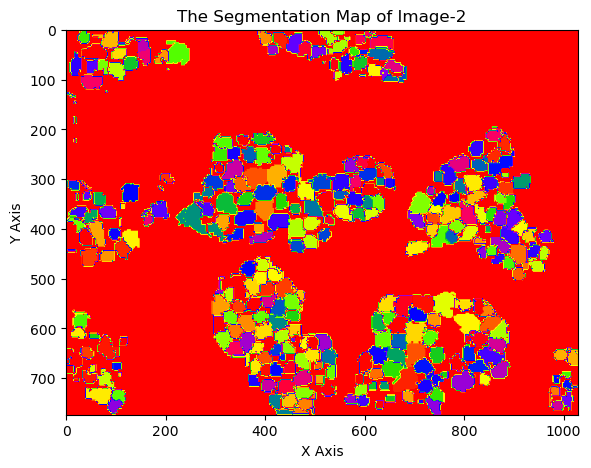

------------------------------------------------------------------------------------------------------------------------
Plots and Metric Values of Part1 are as follows: 

Metrics for the image 3:

Precision: 0.9911611599555716
Recall: 0.936627837130928
F-score: 0.9631231788337817



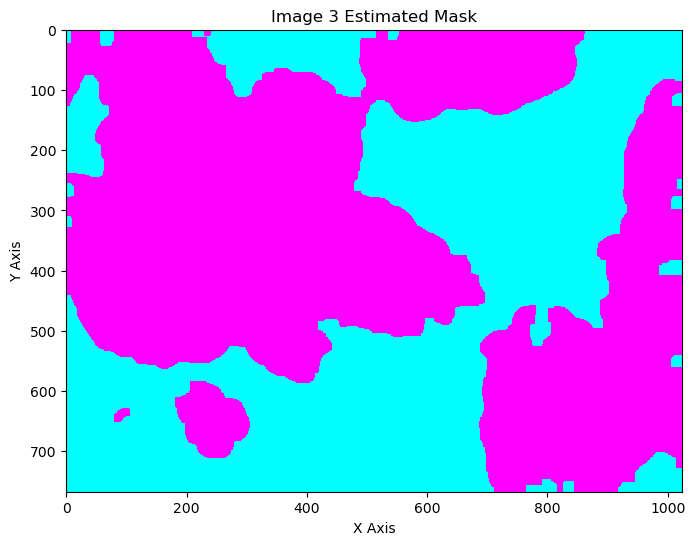

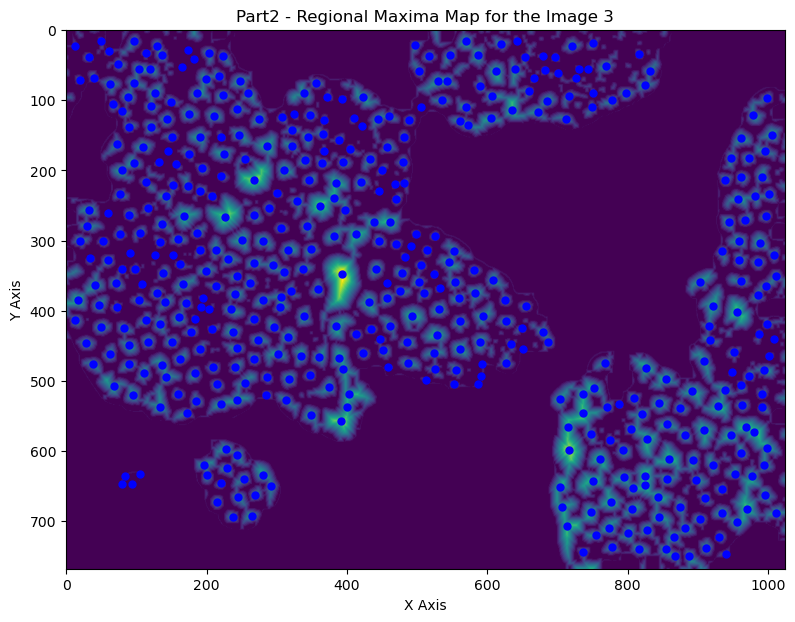

Part-2 Image-3 Metrics:

The cell-level precision, recall, and accuracy metric values for image 3 are as follows: 

Precision: 0.9184549356223176
Recall: 0.8408644400785854
F-score: 0.877948717948718

Cell-level dice index and intersection over union metrics of Part3:

For Threshold being 0.50: 

Dice Index: 0.68
Intersection Over Union: 0.5810526315789474

For Threshold being 0.75: 

Dice Index: 0.4631578947368421
Intersection Over Union: 0.10105263157894737

For Threshold being 0.90: 

Dice Index: 0.010526315789473684
Intersection Over Union: 0.0



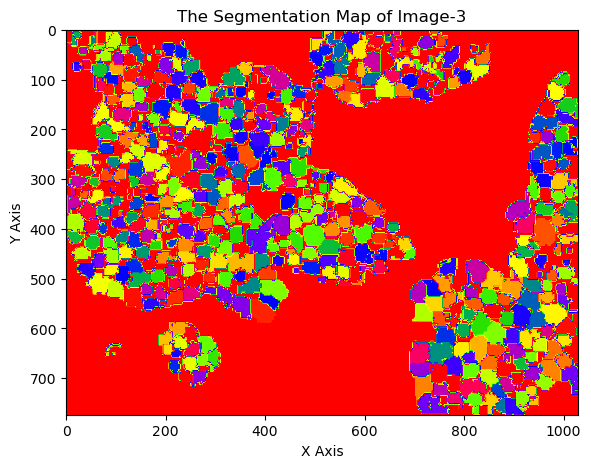

---------------------------------------------------------------------------------------------------------------------


In [1]:
########################################PART1###################################################################################
from matplotlib import pyplot as plt
from queue import Queue
import cv2
import numpy as np
from PIL import Image
from skimage.feature import peak_local_max
from PIL import Image
from cv2 import THRESH_BINARY 
from PIL import Image
from skimage.morphology import binary_opening
from skimage.feature import peak_local_max
from skimage import io
from scipy.spatial.distance import cdist
from scipy.ndimage import distance_transform_edt
from numpy import pad
from PIL import ImageEnhance
import skimage.filters as filters
from cv2 import THRESH_OTSU
from scipy.ndimage import binary_fill_holes
import copy
from PIL.ImageEnhance import Contrast
import cv2
import numpy as np
from PIL import ImageOps
import numpy as np


###Takes cell id and coordinate as parameters, returns the list of cell ids and cell coordinates of neighbors.###
def obtain_successor(cell_location_id, all_coordinates):
    current_row = all_coordinates[0]
    current_col = all_coordinates[1]
    current_row_as_int = int(current_row)
    current_col_as_int = int(current_col)
    
    row_range = range(-1, 2)
    col_range = range(-1, 2)
    
    list_of_successors = list()

    for row_offset in row_range:
        for col_offset in col_range:
            if row_offset == 0 and col_offset == 0: #########if current cell
                continue ######## ignore it
            with_row_offset = current_row_as_int + 3 * row_offset 
            with_column_offset = current_col_as_int + 3 * col_offset 
            successor = list()
            successor.append(cell_location_id)
            successor.append(with_row_offset)
            successor.append(with_column_offset)
            list_of_successors.append(successor)
    
    current_cell_info = [cell_location_id, current_row_as_int, current_col_as_int]
    list_of_successors.append(current_cell_info)
    
    return list_of_successors


#### helper function for thresholding #####
def apply_thresholding(img):
    fg_pixel_thresh = 255 # foreground pixel threshold #
    bg_pixel_thresh = 0 # background pixel threshold #
    otsu = cv2.THRESH_OTSU # otsu flag #
    binary = cv2.THRESH_BINARY # binary flag #
    otsu_plus_binary = otsu + binary
    # application of the thresholding method of otsu #
    threshold, estimated_foreground_mask = cv2.threshold(img, bg_pixel_thresh, fg_pixel_thresh, otsu_plus_binary)
    estimated_foreground_mask = np.array(estimated_foreground_mask) # conversion to numpy array #
    return estimated_foreground_mask

### helper function for preprocessing ###
def preprocess_image(image_file: str) -> np.ndarray:
    enhance_coeff = 1.70
    image = cv2.imread(image_file) # Image reading #
    
    conversion_code = cv2.COLOR_BGR2GRAY  
    grayscale_img = cv2.cvtColor(image, conversion_code)   # Conversion to grayscale #

    pil_image = Image.fromarray(grayscale_img) # conversion from grayscale to a PIl image.

    contrast_object = ImageEnhance.Contrast(pil_image)
    enhanced_pil_image = contrast_object.enhance(enhance_coeff) # Enhancing the contrast of the image #

    median_blurred = cv2.medianBlur(np.array(enhanced_pil_image), 5) # Applying a median blur to the enhanced image #
    return median_blurred

## helper function for postprocessing where several morphological operations are applied ##
def morphological_operations(estimated_msk):
    kernel_size = 13
    structuring_element_1 = cv2.getStructuringElement(cv2.MORPH_RECT, (kernel_size, kernel_size))
    estimated_msk = cv2.morphologyEx(estimated_msk, cv2.MORPH_CLOSE, structuring_element_1)

    dilation_kernel_size = 3
    structuring_element_2 = cv2.getStructuringElement(cv2.MORPH_RECT, (dilation_kernel_size, dilation_kernel_size))
    estimated_msk = cv2.dilate(estimated_msk, structuring_element_2)
    estimated_msk = binary_fill_holes(estimated_msk)

    erosion_kernel_size = 5
    structuring_element_3 = cv2.getStructuringElement(cv2.MORPH_RECT, (erosion_kernel_size, erosion_kernel_size))
    estimated_msk = estimated_msk.astype(np.uint8)
    estimated_msk = cv2.erode(estimated_msk, structuring_element_3)

    ker_size = 7
    structuring_element_4 = cv2.getStructuringElement(cv2.MORPH_RECT, (ker_size, ker_size))
    estimated_msk = cv2.morphologyEx(estimated_msk, cv2.MORPH_CLOSE, structuring_element_4)

    kernel_size = 9
    structuring_element_5 = cv2.getStructuringElement(cv2.MORPH_RECT, (kernel_size, kernel_size))
    estimated_msk = cv2.morphologyEx(estimated_msk, cv2.MORPH_OPEN, structuring_element_5)
    
    opening_kernel_size = 11
    structuring_element_6 = cv2.getStructuringElement(cv2.MORPH_RECT, (opening_kernel_size, opening_kernel_size))
    estimated_msk = cv2.morphologyEx(estimated_msk, cv2.MORPH_OPEN, structuring_element_6)

    return estimated_msk

# function to calculate the true positive, false positive and false negative counter values by comparing estimated and gold masks ##
def calculate_tp_fp_fn_counter_values(estimated_mask, gold_mask_data):
    fneg = 0 # initialize the false negative counter
    tpos = 0 # initialize the true positive counter
    fpos = 0 # initialize the false positive counter
    
    # Calculation of the pixel-level precision, accuracy, and Fscore values
    rnum = estimated_mask.shape[0] # row number #
    cnum = estimated_mask.shape[1] # column number #
    
    rows_range = range(0, rnum) # range for rows
    column_range = range(0, cnum) # range for columns
    
    for index_row in rows_range: # go along all rows
        for index_column in column_range: # go along all columns
            estimated_value = estimated_mask[index_row][index_column]
            gold_value = gold_mask_data[index_row][index_column]
        
            if estimated_value == 1 and gold_value == 0:   # false positive counter incrementation
                fpos = fpos + 1
        
            elif estimated_value == 1 and gold_value == 1: # true positive counter incrementation
                tpos = tpos + 1
        
            elif estimated_value == 0 and gold_value == 1: # false negative counter incrementation
                fneg = fneg + 1
                
            else:
                continue
                
    return (tpos, fpos, fneg)  ##### returninng true positive, false positive, false negative counts as a triple tuple ####


# precision = true_pos / (true_pos + false_pos) #
# function to calculate the precision value #
def evaluate_precision_value(true_positives, false_positives):
    precision_val = 0
    all_positive_predictions = true_positives + false_positives
    if all_positive_predictions == 0: # to deal with the divide by zero error
        precision_val = 0
    precision_val = true_positives / all_positive_predictions
    return precision_val

# recall = true_pos / (true_pos + false_neg) #
# function to calculate the recall value # 
def evaluate_recall_value(true_positives, false_negatives):
    recall_val = 0
    all_actual_positives = true_positives + false_negatives
    if all_actual_positives == 0: # to avoid the divide by zero error
        recall_val = 0
    recall_val = true_positives / all_actual_positives 
    return recall_val

# f_score = (2 * precision * recall) / (precision + recall) #
# function to calculate the fscore value #
def evaluate_fscore_value(a, b):
    f_score = 0
    summation = a + b
    if summation == 0: # to deal with the divide by zero error
        f_score = 0
    f_score = (2 * a * b) / (a + b) 
    return f_score
        
def find_true_pos_and_false_pos_in_cell_location_approximation(locations_of_cells):
    true_positive_counter = 0
    false_positive_counter = 0
    total_number_of_duplicates = 0
    length_of_cells = len(locations_of_cells)
    cells_rng = range(0, length_of_cells)
    arbitrary_value = 800
    
    for cell_index in cells_rng: # iterate over all cells
        is_false_positive = (locations_of_cells[cell_index] == 0) ##### boolean checking if pixel corresponding to false pos
        if is_false_positive: ############ false positive case , in other words, background pixel #####
            false_positive_counter+=1
        else: ##### true positive ########
            duplicate_cell_loc = (locations_of_cells[cell_index] == arbitrary_value)
            if duplicate_cell_loc: # duplicate cell location matching #
                total_number_of_duplicates = total_number_of_duplicates + 1 
                true_positive_counter = true_positive_counter - total_number_of_duplicates ####for counting true positives uniquely
            else: ## different and right location of cell ## 
                true_positive_counter = true_positive_counter + 1 
                total_number_of_duplicates = 0  ### reinitializing the duplicate num ###
        arbitrary_value = locations_of_cells[cell_index] 
        
    return true_positive_counter, false_positive_counter

    
def check_white(dil, first_index, second_index):
    if dil is None:
        return False
    return dil[first_index][second_index] == 255

def find_boundary(img_blr, row_rng, column_rng):
     for index_row in row_rng:
        for index_column in column_rng:
            if img_blr[index_row][index_column] < 180:
                img_blr[index_row][index_column] = 0
            elif img_blr[index_row][index_column] == 180:
                img_blr[index_row][index_column] = 0
            elif img_blr[index_row][index_column] > 180:
                img_blr[index_row][index_column] = 255
            else:
                continue
                
                
print()
print()
for i in range(1, 4):
    #########################PART1###########################################################################################
    gold_mask_txt = "data/im" + str(i) + "_gold_mask.txt"
    gold_mask_data = np.genfromtxt(gold_mask_txt)
    
    image_jpg_file = "data/im"+str(i)+".jpg"
    blurred_img = preprocess_image(image_jpg_file)
    
    # applying thresholding of Otsu #
    estimated_foreground_mask = apply_thresholding(blurred_img)
    
    # applying some morphological operations #
    estimated_foreground_mask = morphological_operations(estimated_foreground_mask)
    
    # calculating the true positive, false positive, and false negative counter values #
    values_of_counters = calculate_tp_fp_fn_counter_values(estimated_foreground_mask, gold_mask_data)
    true_positives, false_positives, false_negatives = values_of_counters
    precision_value = evaluate_precision_value(true_positives, false_positives) # calculate pixel-level precision #
    recall_value = evaluate_recall_value(true_positives, false_negatives) # calculate pixel-level recall #
    f_score_value = evaluate_fscore_value(precision_value, recall_value) # calculate pixel-level fscore #
    
    print("------------------------------------------------------------------------------------------------------------------------")
    print("Plots and Metric Values of Part1 are as follows: ")
    print()
    print("\033[1mMetrics for the image "+str(i)+":\033[0m")
    print()
    ## display precision, recall, and fscore values ##
    print("\033[1mPrecision: \033[0m"+str(precision_value)+"") ###### precision ########
    print("\033[1mRecall: \033[0m"+str(recall_value)+"") ############# recall #################
    print("\033[1mF-score: \033[0m"+str(f_score_value)+"") ################ f-score ##########################
    print()

    # Plotting/showing the estimated foreground mask for the i-th image #
    plt.figure(figsize=(10, 6))
    plt.title('Image ' + str(i) + ' Estimated Mask')
    plt.imshow(estimated_foreground_mask, cmap='cool', interpolation='nearest')
    plt.xlabel("X Axis")
    plt.ylabel("Y Axis")
    plt.show()
    ########################################PART1###############################################################################
    ########################################PART2###############################################################################
    gold_cells_data = np.genfromtxt("data\im"+str(i)+"_gold_cells.txt")
    
    total_row_number = blurred_img.shape[0]
    total_column_number = blurred_img.shape[1]
    
    row_rng = range(total_row_number)
    column_rng = range(total_column_number)
    
    find_boundary(blurred_img, row_rng, column_rng)
      
    blurred_img = cv2.fastNlMeansDenoising(blurred_img,None,4,8,32)
    estimated_foreground_mask = np.array(estimated_foreground_mask)
    size_of_kernel = 5
    erosion_kernel = (size_of_kernel, size_of_kernel)
    fir_structuring_elm = cv2.getStructuringElement(cv2.MORPH_RECT, erosion_kernel)
    mask_structure_of_ero = cv2.erode(blurred_img, fir_structuring_elm)
    
    second_size = 3
    second_ker = (second_size, second_size)
    mask_opening = cv2.morphologyEx(mask_structure_of_ero, cv2.MORPH_OPEN, second_ker)

    
    msk = estimated_foreground_mask[:]

    for loc_row in row_rng:
        for loc_column in column_rng:
            is_white = (check_white(mask_opening, loc_row, loc_column))
            if is_white:
                msk[loc_row][loc_column] = 0
    
    msk = np.array(msk, dtype=np.uint8)
    chebyshev_code = cv2.DIST_C
    distance_trans = cv2.distanceTransform(msk, chebyshev_code, 5)
    
    source = distance_trans
    normalization_type = cv2.NORM_MINMAX
    destination = distance_trans
    alpha_factor_val = 0
    beta_factor_val = 1

    cv2.normalize(source, destination, alpha_factor_val, beta_factor_val, normalization_type)
    regional_maximas = peak_local_max(distance_trans, min_distance=12)
    regional_maximas = np.array(regional_maximas)
    x_coordinates = regional_maximas[:, 0] 
    y_coordinates = regional_maximas[:, 1] 
    locations_of_cells = gold_cells_data[x_coordinates, y_coordinates] 
    if locations_of_cells is None:
        break
    
    plt.figure(figsize=(11, 7))
    plt.title("Part2 - Regional Maxima Map for the Image "+str(i)+"")
    plt.xlabel("X Axis")
    plt.ylabel("Y Axis")
    
    dark_blue = "bo"
    plt.plot(y_coordinates, x_coordinates, dark_blue, markersize=5)
    viridis = "viridis"
    plt.imshow(distance_trans, cmap=viridis)
    plt.show()
    
    
    true_pos, false_pos = find_true_pos_and_false_pos_in_cell_location_approximation(locations_of_cells)
    cells_len = len(locations_of_cells)
    if cells_len == 0:
        break
    
    total_positive_guesses = true_pos + false_pos ########## total number of positive guesses #########
    precision_metric = true_pos / total_positive_guesses
    maximum_boundary = np.max(gold_cells_data)
    recall_metric = true_pos / maximum_boundary # dividing tp value by total num of cell bounds in ground truth
    f_score_metric = evaluate_fscore_value(precision_metric, recall_metric)
    print("Part-2 Image-"+str(i)+" Metrics:")
    print()
    print("The cell-level precision, recall, and accuracy metric values for image "+str(i)+" are as follows: ")
    print()
    print("\033[1mPrecision: \033[0m"+str(precision_metric)+"") 
    print("\033[1mRecall: \033[0m"+str(recall_metric)+"")
    print("\033[1mF-score: \033[0m"+str(f_score_metric)+"")
    ############################################PART2###########################################################################
    ############################################PART3###########################################################################

    pad_width_value = 3
    rng_maxima = range(0, regional_maximas.shape[0])
    deepcopied_mask = msk[:]
    
    rng_row = range(0, total_row_number)
    rng_column = range(0, total_column_number)
    

    deepcopied_mask = np.array(deepcopied_mask, dtype = int)
    deepcopied_mask[deepcopied_mask == 1] = -999 ############ reset or erase current foreground cell pixels#######
    deepcopied_mask = deepcopied_mask.tolist()

    all_regs = list() ############# initialization of all regions as a list################
    already_vis = list()
    padding_mode = "constant"
    
    for approx_cell_loc in rng_maxima:
        reg_max = regional_maximas[approx_cell_loc] ################get regional maxima by its id#############
        cell_id_value = 1 + approx_cell_loc ##################the value of cell id ###############
        successor_regs = obtain_successor(cell_id_value, reg_max) ###############obtaining neighbors################
        all_regs = all_regs + successor_regs
        
    
    padding_val = 0
    deepcopied_mask = pad(deepcopied_mask, mode=padding_mode, constant_values=padding_val, pad_width=pad_width_value) 
    
    reg_len = len(all_regs)

    while True:
        if reg_len <= 0: ############if the region length is not positive, then terminate ##############
            break
        cur_region = all_regs[0]
        id_val = cur_region[0] ####id of cell########
        nei_x = cur_region[1] ####neighbor#############
        nei_y = cur_region[2] ####neighbor#############
        successors_lst = list() ######initializing the list of neighbors########
        successors_lst.append(nei_x) ######appending to list of successors ########
        successors_lst.append(nei_y) ######appending to list of successors ########
        already_vis.append(cur_region)
        neighbor_id1_in_map = 3 + nei_x
        neighbor_id2_in_map = 3 + nei_y
        if deepcopied_mask[neighbor_id1_in_map][neighbor_id2_in_map] != -999:
            pass
        else:#####if pixel is not resetted to different value other than background or foreground pixel value#####
            offset_rng = range(1,6)
            for row_offset in offset_rng:
                for column_offset in offset_rng:
                    deepcopied_mask[row_offset+nei_x][column_offset+nei_y] = id_val #####label the cells in segmentation map and form contigious region in map#####
            for id_val in obtain_successor(id_val, successors_lst): ###traverse all successors
                is_already_visited = (id_val in already_vis)
                if is_already_visited: #####if region is already visited ######
                    continue ######### skip #########
                else:####if successor id not yet visited
                    all_regs.append(id_val) #######grow the current set of regions
        all_regs.pop(0) ###remove first id as it is in region already
        reg_len = len(all_regs) #####update the length of regions list after popping the first element#####


    deepcopied_mask = np.array(deepcopied_mask, dtype = int)
    deepcopied_mask[deepcopied_mask == -999] = 0 #####if a non-existent pixel is left in map, then treat as background####
    deepcopied_mask = deepcopied_mask.tolist()

    dice_ind_scr = list()
    intersection_scr = list()
    

    for loc in rng_maxima:
        false_positives = 0
        true_positives = 0
        pixel_cell_val = -999
        false_negatives = 0
        for row_ind in rng_row:
            for col_ind in rng_column:
                pixel_gold_equal = (gold_cells_data[row_ind][col_ind] == pixel_cell_val)
                is_labelled = ((1 + loc) == deepcopied_mask[row_ind][col_ind]) ##check equality of regional max id and deepcopied mask id##
                is_foreground = (not (gold_cells_data[row_ind][col_ind] == 0))
                if (not pixel_gold_equal) and is_labelled:
                    false_positives = false_positives + 1
                if is_labelled and is_foreground and pixel_cell_val == -999: #####if pixel not in gold cell data######
                    pixel_cell_val = gold_cells_data[row_ind][col_ind] ######## assign pixel to the gold cell pixel ####
                elif (not is_labelled) and pixel_gold_equal: 
                    false_negatives = false_negatives + 1
                elif is_labelled and pixel_gold_equal: ###when estimated id labelled in map and estimated pixel is equal to gold cell pixel###
                    true_positives = true_positives + 1
                else:
                    pass
               
        intersection_numerator = (true_positives)
        intersection_denumerator = (false_negatives + true_positives + false_positives)
        intersection_value = intersection_numerator / intersection_denumerator
        intersection_scr.append(intersection_value)
        
        
        dice_numerator = (2 * true_positives)
        dice_denumerator = (false_negatives + false_positives + (2 * true_positives))
        dice_index_value = dice_numerator / dice_denumerator
        dice_ind_scr.append(dice_index_value)
       
        
        
    first_intersection = 0      ########initializing overlap amount of IOU metric for the first threshold#################
    second_intersection = 0     ########initializing overlap amount of IOU metric for the second threshold#################
    third_intersection = 0      ########initializing overlap amount of IOU metric for the third threshold#################
    
    first_dice = 0              ########initializing overlap amount of dice index metric for the first threshold######
    second_dice = 0             ########initializing overlap amount of dice index metric for the second threshold######
    third_dice = 0              ########initializing overlap amount of dice index metric for the third threshold######
    
    threshold_bounds = list()       ############initializing the list of threshold boundaries##########
    threshold_bounds.append(0.50)   ############appending 0.50 to the list of threshold boundaries##########
    threshold_bounds.append(0.75)   ############appending 0.75 to the list of threshold boundaries##########
    threshold_bounds.append(0.90)   ############appending 0.90 to the list of threshold boundaries##########
    
    inters_len = len(intersection_scr)

    for index_value in range(0, inters_len):
        for bound in threshold_bounds:
            if intersection_scr[index_value] > bound: #####if intersection score more than the bound in threshold bounds####
                if bound == threshold_bounds[0]: #####if the bound is 0.50####
                    first_intersection = first_intersection + 1 #####increment first overlap amount for intersection metric####
                elif bound == threshold_bounds[1]: #####if the bound is 0.75####
                    second_intersection = second_intersection + 1 #####increment second overlap amount for intersection metric####
                elif bound == threshold_bounds[2]: #####if the bound is 0.90####
                    third_intersection = third_intersection + 1 #####increment third overlap amount for intersection metric####
            if dice_ind_scr[index_value] > bound: #####if dice index score more than the bound in threshold bounds####
                if bound == threshold_bounds[2]:  #####if the bound is 0.90####
                    third_dice = third_dice + 1   #####increment third overlap amount for the dice index metric####
                elif bound == threshold_bounds[1]: #####if the bound is 0.75####
                    second_dice = second_dice + 1  #####increment second overlap amount for the dice index metric####
                elif bound == threshold_bounds[0]: #####if the bound is 0.50####
                    first_dice = first_dice + 1    #####increment third overlap amount for the dice index metric####
    
    print()
    print('Cell-level dice index and intersection over union metrics of Part3:')
    print()
    print("For Threshold being 0.50: ")
    print()
    f_dice = first_dice / len(dice_ind_scr)  ############applying the formula of cell-level dice index metric########
    print("Dice Index: " +str(f_dice)+"")

    f_intersection = first_intersection / len(dice_ind_scr) ########applying the formula of cell-level IOU metric#######
    print("Intersection Over Union: " +str(f_intersection)+"")
    print()

    print("For Threshold being 0.75: ")
    print()

    s_dice = second_dice / len(dice_ind_scr)
    print("Dice Index: " +str(s_dice)+"")

    s_intersection = second_intersection / len(dice_ind_scr)
    print("Intersection Over Union: " + str(s_intersection)+"")
    print()
    print("For Threshold being 0.90: ")
    print()

    t_dice = third_dice / len(dice_ind_scr)
    print("Dice Index: " +str(t_dice)+"")

    t_intersection = third_intersection / len(dice_ind_scr)
    print("Intersection Over Union: " +str(t_intersection)+"")
    print()
    plt.figure(figsize=(10, 5))
    plt.xlabel("X Axis")
    plt.ylabel("Y Axis")
    plt.title("The Segmentation Map of Image-"+str(i)+"")
    prism = "prism"
    plt.imshow(deepcopied_mask, cmap=prism)
    plt.show()
    ############################################PART3###########################################################################
print("---------------------------------------------------------------------------------------------------------------------")
    

   


Part4 Pixel-Level Precision, Recall, F-score values and Segmentation Maps are as below: 

----------------------------------------------------------------------------------------------------------------
The pixel-level precision, recall, and f-score metrics of the fundus image fundus/d7_dr.jpg are as follows: 

Precision value: 0.12017720434279987
Recall value: 0.6817610639761522
F-score value: 0.2043352760061579



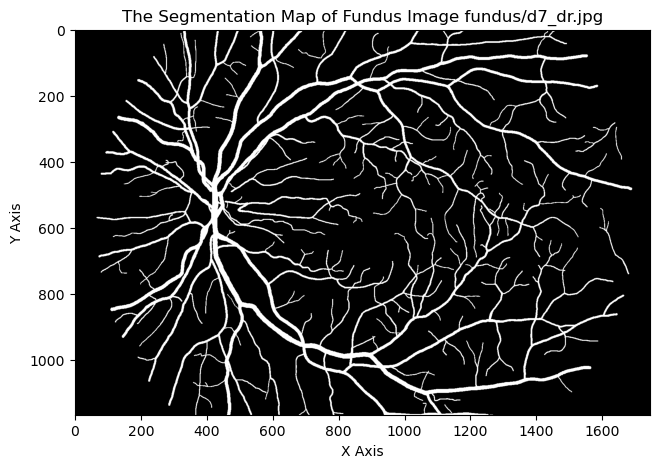

----------------------------------------------------------------------------------------------------------------
The pixel-level precision, recall, and f-score metrics of the fundus image fundus/d4_h.jpg are as follows: 

Precision value: 0.1454234569274367
Recall value: 0.7501050437143457
F-score value: 0.24361674349274579



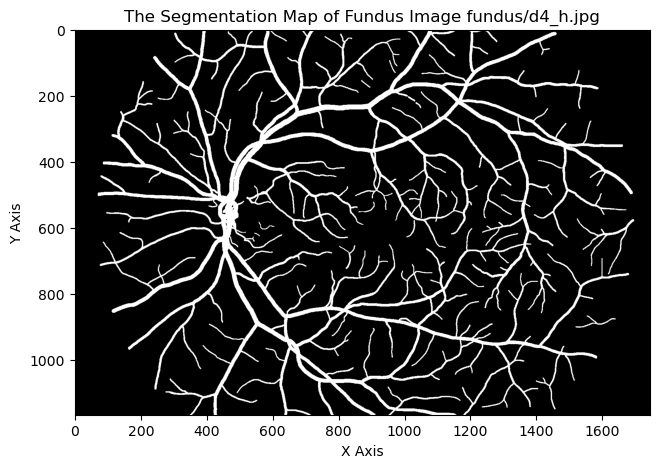

----------------------------------------------------------------------------------------------------------------
The pixel-level precision, recall, and f-score metrics of the fundus image fundus/d11_g.jpg are as follows: 

Precision value: 0.12782447059361732
Recall value: 0.8646043794026101
F-score value: 0.2227214516596969



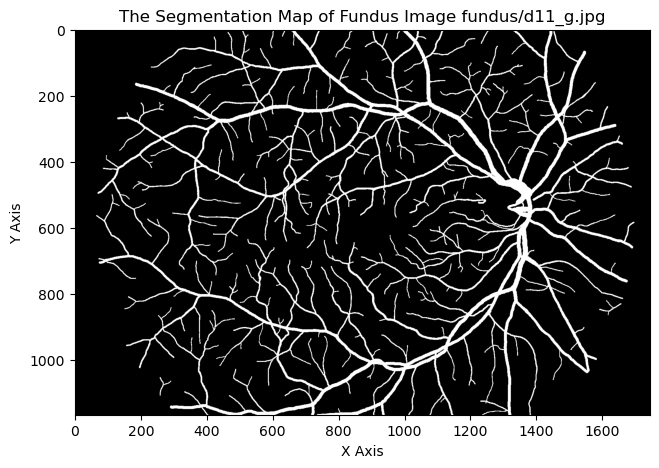

--------------------------------------------------------------------------------------------------------------------


In [3]:
############################################PART4################################################################################
import cv2
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image
from PIL import ImageEnhance

def guess_mask_of_vessels(img_gray):
    img_pil = Image.fromarray(img_gray) 
    contrast_obj = ImageEnhance.Contrast(img_pil)
    enhance_coefficient_value = 1.65
    pil_img_enhanced = contrast_obj.enhance(enhance_coefficient_value)  ###### enhancing the image #######
    numpy_pil = np.array(pil_img_enhanced)
    gaussian_blurred_img = cv2.GaussianBlur(numpy_pil, (11,11), 0) ##################applying gaussian blur ################
    thresh_bin = cv2.THRESH_BINARY
    thresh_otsu = cv2.THRESH_OTSU
    thresh_summation = thresh_bin + thresh_otsu
    thresh_val, estimated_fg_msk = cv2.threshold(gaussian_blurred_img, 0, 1, thresh_summation) ###otsu method with boundaries 0 and 1 as expected###
    estimated_fg_msk = np.array(estimated_fg_msk) 
    estimated_fg_msk = estimated_fg_msk.astype(np.uint8)
    return estimated_fg_msk

def prec_evaluation(msk_gold, est_fg_mask):
    is_true_positive = np.logical_and(msk_gold == 1, est_fg_mask == 1) ### indicating whether logical condition is tp ###
    is_false_positive = np.logical_and(msk_gold == 0, est_fg_mask == 1) ### indicating if the logical condition is fp ###
    true_pos_num = np.sum(is_true_positive) #########summation of all true positives##########
    false_pos_num = np.sum(is_false_positive) #######summation of all false positives#########
    all_positive_guesses = (true_pos_num + false_pos_num) ###total number of positive guesses###
    if all_positive_guesses == 0: ####### for dealing with divide by zero error #########
        return 0 ####### for dealing with divide by zero error ##########
    precision_metric_val = true_pos_num / all_positive_guesses
    return precision_metric_val

def recall_evaluation(msk_gold, estimated_fg_mask):
    is_true_pos = np.logical_and(msk_gold == 1, estimated_fg_mask == 1) ### indicating whether logical condition is tp ###
    is_false_neg = np.logical_and(msk_gold == 1, estimated_fg_mask == 0) ### indicating whether logical condition is fn ###
    number_of_true_pos = np.sum(is_true_pos) ############summation of all true positives#####################
    number_of_false_neg = np.sum(is_false_neg) ##########summation of all false negatives#####################
    all_actual_pos = (number_of_true_pos + number_of_false_neg)
    if all_actual_pos == 0:  ####### for dealing with divide by zero error ###########
        return 0 ####### for dealing with divide by zero error ##########
    recall_val = number_of_true_pos / all_actual_pos
    return recall_val

def fscore_evaluation(val_prec, val_recall):
    f_score = 0
    parameter_sum_val = val_prec + val_recall
    if parameter_sum_val == 0: #################### for handling divide by zero error ############################
        return 0 #################### for handling divide by zero error ############################
    return (2 * val_prec * val_recall) / (val_prec + val_recall)


fundus_images = ["fundus/d7_dr.jpg", "fundus/d4_h.jpg", "fundus/d11_g.jpg"]  #######list of all fundus images########
gold_masks_of_fundus_images = ["fundus/d7_dr_gold.png", "fundus/d4_h_gold.png", "fundus/d11_g_gold.png"] #######gold masks#######

print()
print("Part4 Pixel-Level Precision, Recall, F-score values and Segmentation Maps are as below: ")
print()

for j in range(0,3):
    fundus_name = fundus_images[j]
    gold_mask_name = gold_masks_of_fundus_images[j]
    gray_code = cv2.IMREAD_GRAYSCALE
    
    fundus_img = cv2.imread(fundus_name, gray_code)
    gold_mask = cv2.imread(gold_mask_name, gray_code)
    
    est_mask = guess_mask_of_vessels(fundus_img)
    
    value_of_precision = prec_evaluation(gold_mask, est_mask)
    value_of_recall = recall_evaluation(gold_mask, est_mask)
    value_of_fscore = fscore_evaluation(value_of_precision, value_of_recall)
    print("----------------------------------------------------------------------------------------------------------------")
    print("The pixel-level precision, recall, and f-score metrics of the fundus image "+str(fundus_name)+" are as follows: ")
    print()
    print("Precision value: "+str(value_of_precision)+"")
    print("Recall value: "+str(value_of_recall)+"")
    print("F-score value: "+str(value_of_fscore)+"")
    print()
    plt.figure(figsize=(10, 5))
    plt.xlabel("X Axis")
    plt.ylabel("Y Axis")
    plt.title("The Segmentation Map of Fundus Image "+str(fundus_name)+"")
    gold_mask_one = np.array(gold_mask == 1) ########### for visualizing gold == 1 ###############
    plt.imshow(gold_mask_one, cmap="gray") ################ visualization of gold == 1 with a grayscale format ################
    plt.show()

print("--------------------------------------------------------------------------------------------------------------------")
    
     
############################################PART4##############################################################################

    